# Problem Set 5:

##### Due October 21st at 11:59pm

<div>
<img src="problems/1.png" width="600">
</div>

In [1]:
import numpy as np
import camb
from matplotlib import pyplot as plt


def get_spectrum(pars,lmax=3000):
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]
    return tt[2:]

pars1=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model1=get_spectrum(pars1)
model1=model1[:len(spec)]
resid1=spec-model1
chisq1=np.sum( (resid1/errs)**2)

pars2=np.asarray([69, 0.022, 0.12,0.06, 2.1e-9, 0.95])
model2=get_spectrum(pars2)
model2=model2[:len(spec)]
resid2=spec-model2
chisq2=np.sum( (resid2/errs)**2)

print("Chisquare is {} with {} degress of freedom with parameters:\n H0={}, ombh2={}, omch2={}, tau={}, As={}, ns={}".format(chisq1, len(resid1)-len(pars1), pars1[0], pars1[1], pars1[2], pars1[3], pars1[4], pars1[5]))
print("Chisquare is {} with {} degress of freedom with parameters:\n H0={}, ombh2={}, omch2={}, tau={}, As={}, ns={}".format(chisq2, len(resid2)-len(pars2), pars2[0], pars2[1], pars2[2], pars2[3], pars2[4], pars2[5]))

Chisquare is 15267.937150261658 with 2501 degress of freedom with parameters:
 H0=60.0, ombh2=0.02, omch2=0.1, tau=0.05, As=2e-09, ns=1.0
Chisquare is 3272.2053559202186 with 2501 degress of freedom with parameters:
 H0=69.0, ombh2=0.022, omch2=0.12, tau=0.06, As=2.1e-09, ns=0.95


###### Are the parameters an acceptable fit?
For parameters $H_0=60$, $\Omega_bh^2$=0.02, $\Omega_ch^2=0.1$, $\tau=0.05$, $A_s=2\cdot10^{-9}$, $n_s=1.0$:

With these given parameters, we obtain a $\chi^2$ value of around 15,268 with 2501 degrees of freedom, indicating that our fit is not even close to being accurate to the data since $\chi^2$ is 6 times the number of degrees of freedom.

For parameters $H_0=69$, $\Omega_bh^2$=0.022, $\Omega_ch^2=0.12$, $\tau=0.06$, $A_s=2.1\cdot10^{-9}$, $n_s=0.95$:

With these given parameters, we obtain a $\chi^2$ value of 3,272.2053559202186 with 2501 degrees of freedom, indicating that our fit is much better than the previous fit, but still far from being an accurate representation of the data since our $\chi^2$ still gives a miniature acceptance value.

<div>
<img src="problems/2.png" width="600">
</div>

  0%|          | 0/10 [00:00<?, ?it/s]

Best Fit parameters and errors from Newton Fit:
H0=68.2±1.18
ombh2=0.0224±0.00023
omch2=0.118±0.0026
tau=0.085±0.034
As=2.2e-09±1.4e-10
ns=0.973±0.0065
With a chisquare value of 2576.15


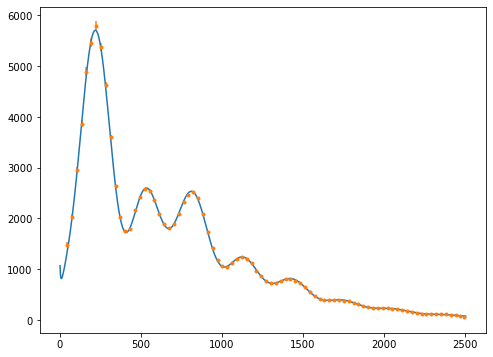

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#same code as in problem set 4
def partial_deriv_CAMB(x, params):
    dx = np.diag(1e-16**(1/3)*params)
    A = np.empty([len(x), len(params)])
    for i in range(len(params)):
        A[:,i] = (get_spectrum(params+dx[i])[:len(spec)]-get_spectrum(params)[:len(spec)])/dx[i][i]
    return A

def CMB(params, x):
    y = get_spectrum(params)[:len(spec)]
    A = partial_deriv_CAMB(x, params)
    return y, A

def chi(params, x, y, errs):
    fit = get_spectrum(params)[:len(spec)]
    resid = y-fit
    chsq = np.sum((resid/errs)**2)
    return chsq

#param guess
guess = np.array([69, 0.022, 0.12,0.06, 2.1e-9, 0.95])

noise = np.diag(errs**2)
ninv = np.linalg.inv(noise)
runs = 10
chsq = np.empty(runs)

#newton fit
for i in tqdm(range(runs)):
    pred, A = CMB(guess,ell)
    resid = spec-pred
    chsq[i] = np.sum((resid/errs)**2)
    LHS = A.T@ninv@A
    RHS = A.T@ninv@resid
    dg = np.linalg.inv(LHS)@RHS
    guess += dg

Newt_fit, A = CMB(guess, ell)

cov = np.linalg.inv(LHS)
Nerrs = np.sqrt(np.diag(cov))

planck_binned=np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);

print('Best Fit parameters and errors from Newton Fit:\nH0={}±{}\nombh2={}±{}\nomch2={}±{}\ntau={}±{}\nAs={}±{}\nns={}±{}\nWith a chisquare value of {}'.format(round(guess[0], 1), round(Nerrs[0], 2), round(guess[1], 4), round(Nerrs[1], 5), round(guess[2], 3), round(Nerrs[2], 4), round(guess[3], 3), round(Nerrs[3], 3), round(guess[4], 10), round(Nerrs[4], 11), round(guess[5], 3), round(Nerrs[5], 4), round(chi(guess, ell, spec, errs), 2)))

plt.figure(figsize=(8,6))
plt.plot(ell,Newt_fit)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

print()

In [52]:
params = np.empty((len(guess),2))

for i in range(len(params)):
    params[i,0] = guess[i]
    params[i,1] = Nerrs[i]

np.savetxt('mcmc/planck_fit_params.txt', params)

<div>
<img src="problems/3.png" width="600">
</div>

In [4]:
#ran on a seperate computer
nstep = 20000 #number of steps
guess = np.array([69, 0.022, 0.12,0.06, 2.1e-9, 0.95])

def MCMC(params, x, y, errs, covmat, nstep):
    chain = np.zeros([nstep,len(params)+1]) #initializing the chain
    chsq = chi(params, x, y, errs) #initial chisquare
    chain[0,:] = np.append(chsq,params) 
    for i in tqdm(range(1,nstep)):
        new_params = chain[i-1,1:]+np.random.multivariate_normal(np.zeros(len(params)), covmat)
                                #inital step in direction based off
                                #the covariance matrix
        new_chsq = chi(new_params, x, y, errs)
                                #calculate chisquare at new position
        accept = np.exp(-0.5*(new_chsq-chain[i-1,0])) #acceptance eq
        if accept>np.random.rand(1): #if the step dimishes chisquare,
                                #take it. If it increases it by a bit,
                                #take it sometimes
            chain[i,:] = np.append(new_chsq, new_params)
        else:
            chain[i,:] = chain[i-1,:]
    return chain

#chain = MCMC(guess, ell, spec, errs, cov, nstep)

#np.savetxt('mcmc/planck_chain.txt', chain)

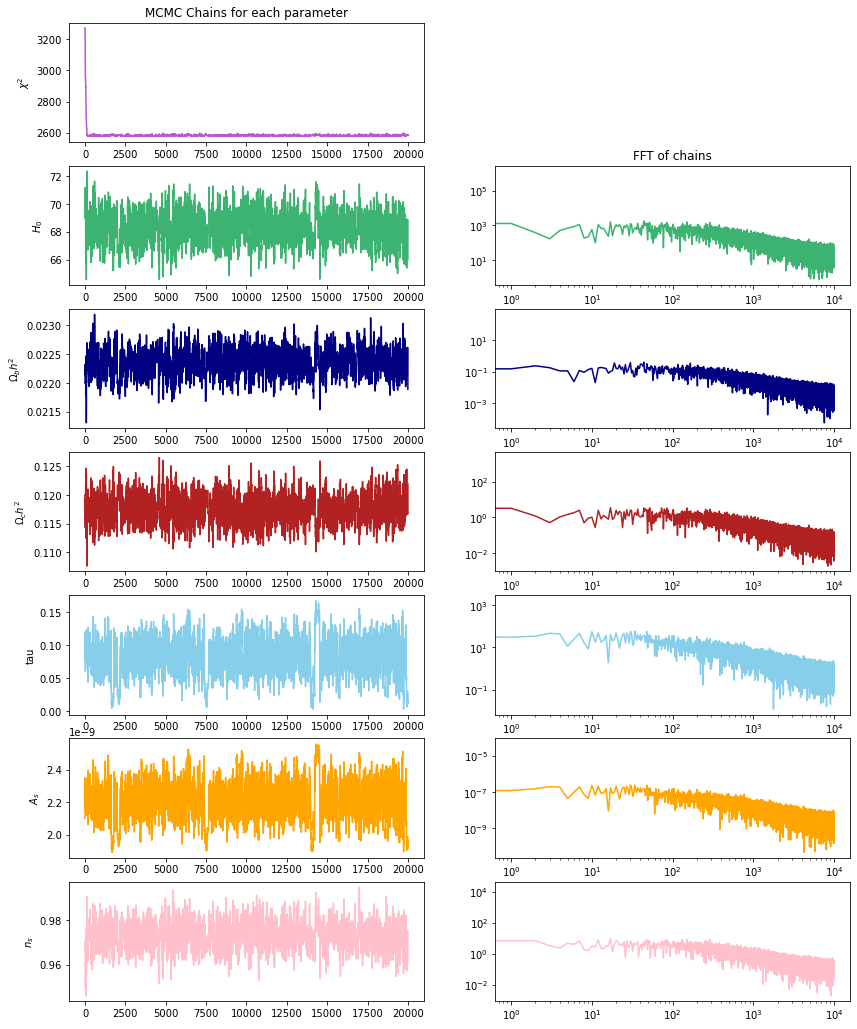

In [35]:
param_names = ['$\chi^2$', '$H_0$', '$\Omega_bh^2$', '$\Omega_ch^2$', 'tau', '$A_s$', '$n_s$']
colours = ['mediumorchid','mediumseagreen','navy','firebrick','skyblue','orange','pink']
chain = np.loadtxt('mcmc/planck_chain.txt')

#plotting chains
plt.figure(figsize=(14,18))
plt.subplot(7,2,1)
plt.title('MCMC Chains for each parameter')
plt.subplot(7,2,4)
plt.title('FFT of chains')
for i in range(len(param_names)):
    plt.subplot(7,2,2*i+1)
    plt.plot(chain[:,i], color=colours[i])
    plt.ylabel(param_names[i])
    if i!=0:
        plt.subplot(7,2,2*i+2)
        plt.loglog(abs(np.fft.rfft(chain[:,i])), color=colours[i])

As we can see by looking at both the chains for each parameter and the FFTs of said chains, we can determine that the chains have converged. By looking solely at the chains, we see that they appear to resemble white noise, indicating the convergence of the parameters. By looking at the FFts, we can see that they all stay pretty flat (indicating white noise) until ~$10^2$ where they all begin to fall off (indicating correlated noise).

Best Fit parameters and errors from MCMC:
H0=68.3±1.08
ombh2=0.0224±0.00022
omch2=0.118±0.0024
tau=0.082±0.03
As=2.2e-09±1.3e-10
ns=0.973±0.0061
With a chisquare value of 2577.5


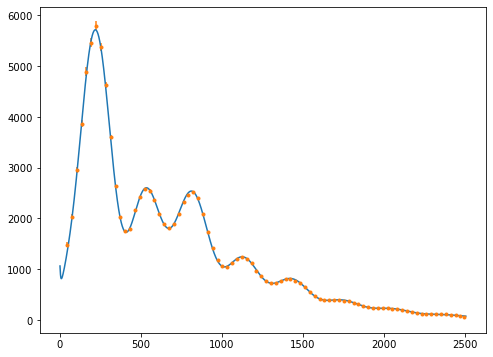

In [19]:
#comparing the error bars
mcmc_params = np.empty(len(guess))
mcmc_errs = np.empty(len(guess))
for i in range(len(guess)):
    mcmc_params[i] = np.mean(chain[200:,i+1])
    mcmc_errs[i] = np.std(chain[200:,i+1])

print('Best Fit parameters and errors from MCMC:\nH0={}±{}\nombh2={}±{}\nomch2={}±{}\ntau={}±{}\nAs={}±{}\nns={}±{}\nWith a chisquare value of {}'.format(round(mcmc_params[0], 1), round(mcmc_errs[0], 2), round(mcmc_params[1], 4), round(mcmc_errs[1], 5), round(mcmc_params[2], 3), round(mcmc_errs[2], 4), round(mcmc_params[3], 3), round(mcmc_errs[3], 3), round(mcmc_params[4], 10), round(mcmc_errs[4], 11), round(mcmc_params[5], 3), round(mcmc_errs[5], 4), round(chi(mcmc_params, ell, spec, errs), 2)))

plt.figure(figsize=(8,6))
plt.plot(ell, get_spectrum(mcmc_params)[:len(spec)])
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

In [53]:
#calculating each density and propagating the error
h2 = (mcmc_params[0]/100)**2
err_h2 = h2*(mcmc_errs[0]/mcmc_params[0])*2 #error propagation

#calculate omb and propagate error
omb = mcmc_params[1]/h2
err_omb = mcmc_params[1]/h2*np.sqrt((mcmc_errs[1]/mcmc_params[1])**2+(err_h2/h2)**2)

#calculate omc and propagate error
omc = mcmc_params[2]/h2
err_omc = mcmc_params[2]/h2*np.sqrt((mcmc_errs[2]/mcmc_params[2])**2+(err_h2/h2)**2)

#calculate oma using omb and omc and propagate error
oma = 1-omb-omc
err_oma = np.sqrt(err_omb**2+err_omc**2)

print('From the MCMC chain, we can estimate the mean value of dark energy to be {}±{}.'.format(round(oma, 2), round(err_oma, 3)))

From the MCMC chain, we can estimate the mean value of dark energy to be 0.7±0.01.


<div>
<img src="problems/4.png" width="600">
</div>

In [8]:
def importance_sample(chain, t, t_err):
    diff = chain[:,3]-t #difference between tau value from mcmc
                        #and constrained value for tau at each step
    weights = np.exp(-0.5*diff**2/t_err**2) #Weighting the "importance"
                        #of each step based off its "distance" from the
                        #constrained value for tau
    n = chain.shape[1]
    tot = np.empty(n)
    totsq = np.empty(n)
    for i in range(n):
        tot[i] = np.sum(weights*chain[:,i])
        totsq[i] = np.sum(weights*chain[:,i]**2)
    params = tot/np.sum(weights)
    meansq = totsq/np.sum(weights)
    err = np.sqrt(meansq-params**2)
    return params, err, weights

Best Fit parameters and errors from Importance Sampling:
H0=67.8±0.94
ombh2=0.0223±0.00021
omch2=0.119±0.0021
tau=0.055±0.007
As=2.1e-09±3e-11
ns=0.971±0.0053
With a chisquare value of 2577.1


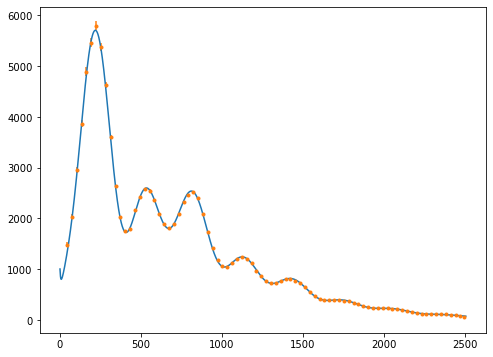

In [16]:
ISparams, ISerrs, weights = importance_sample(chain[:,1:], 0.054, 0.0074)

print('Best Fit parameters and errors from Importance Sampling:\nH0={}±{}\nombh2={}±{}\nomch2={}±{}\ntau={}±{}\nAs={}±{}\nns={}±{}\nWith a chisquare value of {}'.format(round(ISparams[0], 1), round(ISerrs[0], 2), round(ISparams[1], 4), round(ISerrs[1], 5), round(ISparams[2], 3), round(ISerrs[2], 4), round(ISparams[3], 3), round(ISerrs[3], 3), round(ISparams[4], 10), round(ISerrs[4], 11), round(ISparams[5], 3), round(ISerrs[5], 4), round(chi(ISparams, ell, spec, errs), 2)))

plt.figure(figsize=(8,6))
plt.plot(ell, get_spectrum(ISparams)[:len(spec)])
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

In [54]:
g=ISparams
g[3]=0.0540

newcov = np.cov(chain[:,1:].T, aweights = weights) #new covariance is based off our
                        #initial chain, but weighted by the constraint on tau

#same as MCMC except for acceptance equation
def MCMC2(params, x, y, errs, covmat, nstep, t, t_err):
    chain = np.zeros([nstep,len(params)+1])
    chsq = chi(params, x, y, errs)
    chain[0,:] = np.append(chsq,params) 
    for i in tqdm(range(1,nstep)):
        new_params = chain[i-1,1:]+np.random.multivariate_normal(np.zeros(len(params)), covmat)
        new_chsq = chi(new_params, x, y, errs)
        accept = np.exp(-0.5*(new_chsq-chain[i-1,0]+(new_params[3]-t)**2/t_err**2))
                            #we need to weight our chisquare value based on the
                            #calculated parameter for tau so that we maintain
                            #the constraint on tau. We use the same weighting
                            #equation as in our importance sampler
        if accept>np.random.rand(1):
            chain[i,:] = np.append(new_chsq, new_params)
        else:
            chain[i,:] = chain[i-1,:]
    return chain

nstep = 10000

chain2 = MCMC2(g, ell, spec, errs, newcov, nstep, 0.0540, 0.0074)

np.savetxt('mcmc/planck_chain_tauprior.txt', chain2)

  0%|          | 0/9999 [00:00<?, ?it/s]

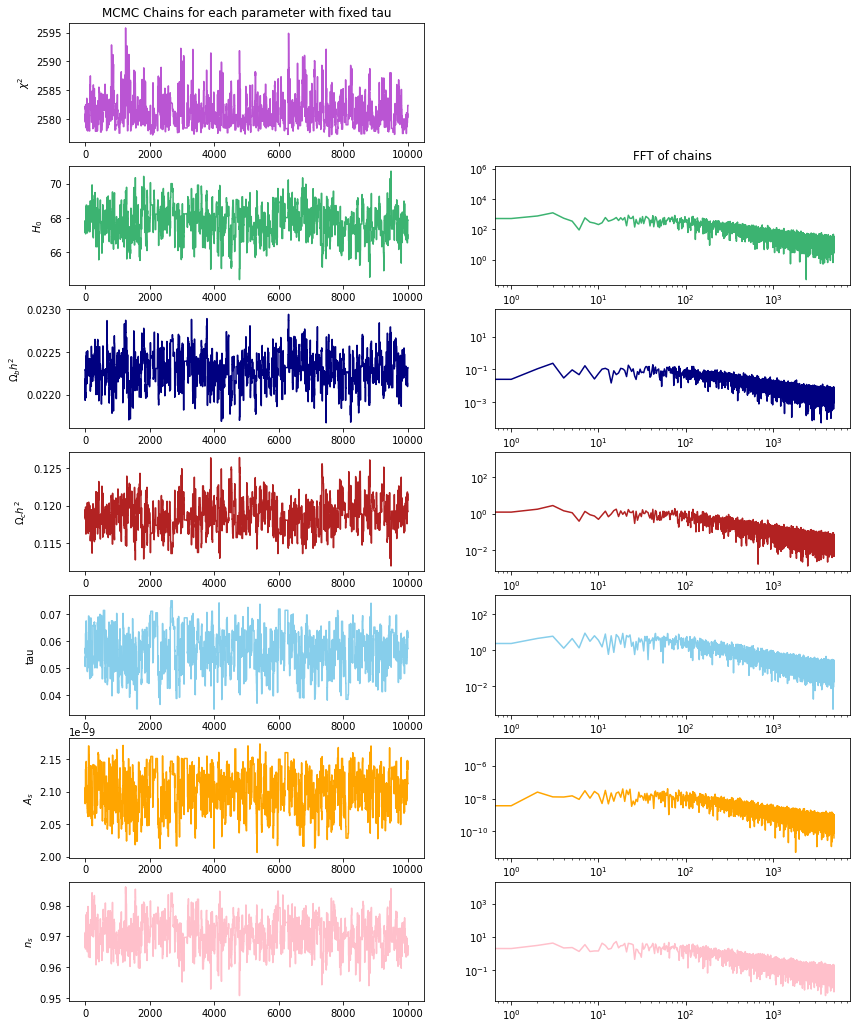

In [55]:
chain2 = np.loadtxt('mcmc/planck_chain_tauprior.txt')

#plotting chains
plt.figure(figsize=(14,18))
plt.subplot(7,2,1)
plt.title('MCMC Chains for each parameter with fixed tau')
plt.subplot(7,2,4)
plt.title('FFT of chains')
for i in range(len(param_names)):
    plt.subplot(7,2,2*i+1)
    plt.plot(chain2[:,i], color=colours[i])
    plt.ylabel(param_names[i])
    if i!=0:
        plt.subplot(7,2,2*i+2)
        plt.loglog(abs(np.fft.rfft(chain2[:,i])), color=colours[i])

Best Fit parameters and errors from MCMC with fixed tau:
H0=67.8±0.92
ombh2=0.0223±0.00019
omch2=0.119±0.0021
tau=0.057±0.008
As=2.1e-09±3e-11
ns=0.971±0.005
With a chisquare value of 2576.98


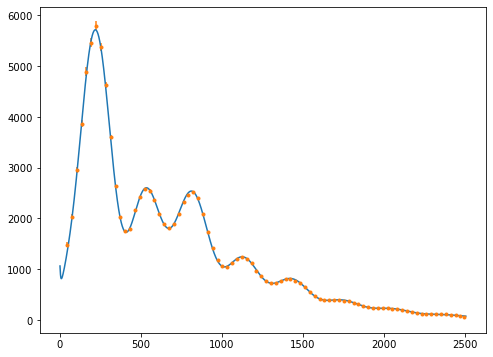

In [56]:
mcmc2_params = np.empty(len(guess))
mcmc2_errs = np.empty(len(guess))
for i in range(len(guess)):
    mcmc2_params[i] = np.mean(chain2[200:,i+1])
    mcmc2_errs[i] = np.std(chain2[200:,i+1])

print('Best Fit parameters and errors from MCMC with fixed tau:\nH0={}±{}\nombh2={}±{}\nomch2={}±{}\ntau={}±{}\nAs={}±{}\nns={}±{}\nWith a chisquare value of {}'.format(round(mcmc2_params[0], 1), round(mcmc2_errs[0], 2), round(mcmc2_params[1], 4), round(mcmc2_errs[1], 5), round(mcmc2_params[2], 3), round(mcmc2_errs[2], 4), round(mcmc2_params[3], 3), round(mcmc2_errs[3], 3), round(mcmc2_params[4], 10), round(mcmc2_errs[4], 11), round(mcmc2_params[5], 3), round(mcmc2_errs[5], 4), round(chi(mcmc2_params, ell, spec, errs), 2)))

plt.figure(figsize=(8,6))
plt.plot(ell, get_spectrum(mcmc_params)[:len(spec)])
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

For our new chain, the only things we want to change are setting the tau value of the initial guess to 0.054, using a new covariance matrix for our step size, and modifying the acceptance equation (the likelihood). To generate this new covariance matrix, I used np.cov using the chain we generated earlier and the weights we determined from the importance sampling. To modify the likelihood, we simply needed to multiply the acceptance equation $e^{-\frac{1}{2}\delta\chi^2}$ by our weighting function $e^{-\frac{1}{2}\frac{\delta\tau^2}{\sigma_{\tau}^2}}$.

By doing this, I was able to find parameters with a slightly better $\chi^2$ than our first chain, but still not better than our importance sampling. Had the step size been even longer, most likely the 2nd chain would eventually reach the same results as the importance sampling. This goes to show how useful importance sampling is, as we were able to obtain a better value for $\chi^2$ without needing to run a new chain.